In [1]:
import model_functions as mod_func

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from gensim import corpora, models, similarities, matutils

from matplotlib import pyplot as plt

import pickle

from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import nltk
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag

import re
import string

from textblob import TextBlob

In [4]:
# Dropping artists without lyrics
df = pd.read_csv('lyrics_by_artist.csv')
df = df.loc[df.Artist != 'Mark Nevers']
df = df.loc[df.Artist != 'Noah Count']
df = df.loc[df.Artist != 'Aphex Twin']
df = df.loc[df.Artist != 'Malibu']
df = df.loc[df.Artist != 'Queen']
df = df.loc[df.Artist != 'Oneohtrix Point Never']
df = df.loc[df.Artist != 'Four Tet']
df = df.loc[df.Artist != '404']
df = df.dropna(subset=['Lyrics','Artist'])

In [5]:
# Lemmatization
df['Lyrics'] = df['Lyrics'].apply(lambda row: mod_func.nouns_adj(row))
df['Lyrics']
df['toked'] = df['Lyrics'].apply(lambda row: mod_func.tokenizer.tokenize(row))
df['lemmed'] = df['toked'].apply(lambda x: [mod_func.wnl.lemmatize(y) for y in x])
df['lemmed'] = df['lemmed'].apply(lambda x: mod_func.undo_list(x))
df['Lyrics'] = df['lemmed']
df = df.drop(columns = ['toked','lemmed'])

In [6]:
df = df.reset_index()
df = df.drop(['index'], axis=1)
#df = df.drop(['level_0'], axis=1)
df

,Artist,Lyrics
0,21 Savage,poppin wheelies banshee male groupie fan man ...
1,A Tribe Called Quest,qtip qtip phife dawg yo ready yo phife ready ...
2,A$AP Rocky,outta place kinda late tryna home safe tina t...
3,ANOHNI,only only only only only only only only degre...
4,Amen Dunes,i cant deny dont i kid i afraid theyre playin...
5,Angel Olsen,new fingertip right i thought dream i youre m...
6,Arca,letra coro anoche te tu figura y tus brazos a...
7,Arcade Fire,summer i arm i letter i feeling i better i ag...
8,Arctic Monkeys,spoken classic reeboks con tracky bottom sock...
9,Ariana Grande,thought id sean match song ricky listen laugh...


In [7]:
# Adding stop words
add_stop_words = ['baby','yeah','wanna','well','thing','yeah','these','pre','ah','cause','did','gonna','aint','gonna',
                  'em','gon','ayy','uh','wont','said','ya','la','eh','ya','gotta','got','youre','ive','come','way',
                  'come','say','huh','oh','ill','thats','wa','let','ooh','nah','yuh','tell','want','time','ima',
                  'really','youve','look','stop','new','mi','yo','el','da','na','away','que','ha','hey','en','te','lo',
                  'ey','soy','yeh','boy','girl','bout','kendrick','lamar','man','bad','good','right']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

**First Round LDA**

In [8]:
count_vec = CountVectorizer(stop_words=stop_words, max_df=0.8, min_df=0.1, ngram_range=(1,1))
words_df = count_vec.fit_transform(df.Lyrics)

In [9]:
with open('count_vec.pickle', 'wb') as to_write:
    pickle.dump(count_vec, to_write)

In [10]:
words_df = words_df.transpose()
corpus = matutils.Sparse2Corpus(words_df)
id2word = dict((v, k) for k, v in count_vec.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=2, id2word=id2word, passes=100, random_state=11)

In [11]:
lda.print_topics(num_words=20)

[(0,
  '0.061*"nigga" + 0.050*"bitch" + 0.031*"shit" + 0.026*"money" + 0.022*"fuck" + 0.014*"real" + 0.010*"life" + 0.009*"world" + 0.009*"big" + 0.009*"young" + 0.008*"hoe" + 0.007*"bag" + 0.007*"damn" + 0.007*"pussy" + 0.007*"day" + 0.007*"dick" + 0.007*"lil" + 0.007*"black" + 0.006*"hook" + 0.006*"high"'),
 (1,
  '0.026*"love" + 0.021*"night" + 0.016*"day" + 0.016*"heart" + 0.014*"eye" + 0.011*"life" + 0.011*"light" + 0.010*"mind" + 0.009*"home" + 0.009*"world" + 0.008*"little" + 0.007*"head" + 0.007*"hand" + 0.007*"friend" + 0.007*"dream" + 0.007*"body" + 0.006*"place" + 0.006*"blood" + 0.006*"better" + 0.006*"hard"')]

In [12]:
docTopicProbMat = lda[corpus]
csr = matutils.corpus2csc(docTopicProbMat)
doc_top = csr.T.toarray()
doc_top_df = pd.DataFrame(doc_top, columns=['topic_1','topic_2'])
full_df = pd.merge(df, doc_top_df, left_index=True, right_index=True)
full_df

,Artist,Lyrics,topic_1,topic_2
0,21 Savage,poppin wheelies banshee male groupie fan man ...,0.991424,0.000000
1,A Tribe Called Quest,qtip qtip phife dawg yo ready yo phife ready ...,0.485295,0.514705
2,A$AP Rocky,outta place kinda late tryna home safe tina t...,0.810271,0.189729
3,ANOHNI,only only only only only only only only degre...,0.046291,0.953709
4,Amen Dunes,i cant deny dont i kid i afraid theyre playin...,0.000000,0.997491
5,Angel Olsen,new fingertip right i thought dream i youre m...,0.000000,0.998217
6,Arca,letra coro anoche te tu figura y tus brazos a...,0.492095,0.507905
7,Arcade Fire,summer i arm i letter i feeling i better i ag...,0.000000,0.998485
8,Arctic Monkeys,spoken classic reeboks con tracky bottom sock...,0.000000,0.997486
9,Ariana Grande,thought id sean match song ricky listen laugh...,0.117887,0.882113


In [13]:
with open('first_lda.pickle', 'wb') as to_write:
    pickle.dump(lda, to_write)

**K-Means Clustering**

In [14]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
import seaborn as sns

In [15]:
#X = StandardScaler().fit_transform(full_df[['topic_1','topic_2']])
X = full_df[['topic_1','topic_2']]

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

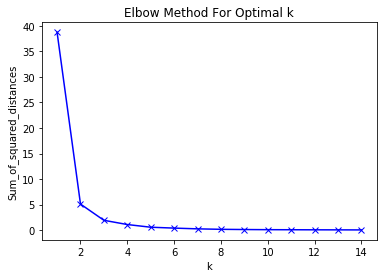

In [16]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [17]:
num_clusters = 2
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=50)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=10, tol=0.0001, verbose=0)

In [18]:
km.inertia_

5.107801601092636

In [19]:
km_results = full_df
km_results['km_cluster'] = km.labels_
km_results.shape

(170, 5)

In [20]:
km_results

,Artist,Lyrics,topic_1,topic_2,km_cluster
0,21 Savage,poppin wheelies banshee male groupie fan man ...,0.991424,0.000000,1
1,A Tribe Called Quest,qtip qtip phife dawg yo ready yo phife ready ...,0.485295,0.514705,1
2,A$AP Rocky,outta place kinda late tryna home safe tina t...,0.810271,0.189729,1
3,ANOHNI,only only only only only only only only degre...,0.046291,0.953709,0
4,Amen Dunes,i cant deny dont i kid i afraid theyre playin...,0.000000,0.997491,0
5,Angel Olsen,new fingertip right i thought dream i youre m...,0.000000,0.998217,0
6,Arca,letra coro anoche te tu figura y tus brazos a...,0.492095,0.507905,1
7,Arcade Fire,summer i arm i letter i feeling i better i ag...,0.000000,0.998485,0
8,Arctic Monkeys,spoken classic reeboks con tracky bottom sock...,0.000000,0.997486,0
9,Ariana Grande,thought id sean match song ricky listen laugh...,0.117887,0.882113,0


In [21]:
with open('kmeans.pickle', 'wb') as to_write:
    pickle.dump(km, to_write)

**LDA on hiphop**

In [22]:
df_hiphop = full_df.copy()
df_hiphop = full_df.drop(['topic_1','topic_2'], axis=1)
df_hiphop = df_hiphop.loc[df_hiphop['km_cluster'] == 1].reset_index()
df_hiphop = df_hiphop.drop(['index'], axis=1)
df_hiphop.head()

,Artist,Lyrics,km_cluster
0,21 Savage,poppin wheelies banshee male groupie fan man ...,1
1,A Tribe Called Quest,qtip qtip phife dawg yo ready yo phife ready ...,1
2,A$AP Rocky,outta place kinda late tryna home safe tina t...,1
3,Arca,letra coro anoche te tu figura y tus brazos a...,1
4,Bad Bunny,letra ft diplo juju yehyeahyeah yeahyeahyeahy...,1


In [23]:
hiphop_add_stop_words = ['dont','thats','cause','way','baby','aint','good','em','uh','ooh','wanna',
                         'okay','playboi','carti','real','phife','huh','let','woah','yo','cardi','eh','lamar',
                         'kendrick','thing','oh','youre','yuh','hook','thing','chief','ey','nigga','ah','ya','gotta','set'
                         'boy','man','day','little','ive','right','nah','ima','kanye','west','girl','boy','shit','ill',
                         'gon','hey']
hiphop_stop_words = text.ENGLISH_STOP_WORDS.union(hiphop_add_stop_words)

In [24]:
hiphop_vec = CountVectorizer(stop_words=hiphop_stop_words, max_df=0.5, min_df=0.05, ngram_range=(1,1))
words_hiphop = hiphop_vec.fit_transform(df_hiphop.Lyrics)

In [25]:
with open('hiphop_vec.pickle', 'wb') as to_write:
    pickle.dump(hiphop_vec, to_write)

In [26]:
words_hiphop = words_hiphop.transpose()
hiphop_corpus = matutils.Sparse2Corpus(words_hiphop)
id2word_hiphop = dict((v, k) for k, v in hiphop_vec.vocabulary_.items())
lda_hiphop = models.LdaModel(corpus=hiphop_corpus, num_topics=3, id2word=id2word_hiphop, passes=100, random_state=11)

In [27]:
lda_hiphop.print_topics(num_words=20)

[(0,
  '0.005*"people" + 0.005*"heart" + 0.004*"light" + 0.004*"wall" + 0.004*"body" + 0.004*"somebody" + 0.004*"blunt" + 0.004*"better" + 0.004*"yall" + 0.003*"sound" + 0.003*"song" + 0.003*"anybody" + 0.003*"everybody" + 0.003*"lie" + 0.003*"feelin" + 0.003*"dead" + 0.003*"mouth" + 0.003*"room" + 0.003*"pussy" + 0.003*"crazy"'),
 (1,
  '0.009*"lil" + 0.008*"pussy" + 0.007*"rich" + 0.007*"diamond" + 0.006*"shawty" + 0.006*"ballin" + 0.006*"drip" + 0.005*"chance" + 0.005*"lit" + 0.005*"lean" + 0.005*"ho" + 0.005*"rapper" + 0.005*"beep" + 0.005*"cash" + 0.005*"rick" + 0.005*"ross" + 0.005*"ayy" + 0.005*"woo" + 0.005*"old" + 0.005*"check"'),
 (2,
  '0.071*"que" + 0.041*"mi" + 0.034*"te" + 0.034*"la" + 0.018*"lo" + 0.018*"ali" + 0.018*"el" + 0.013*"qu" + 0.013*"por" + 0.012*"tu" + 0.012*"se" + 0.012*"di" + 0.011*"soy" + 0.011*"como" + 0.011*"verso" + 0.011*"yeh" + 0.011*"bunny" + 0.010*"ti" + 0.010*"pas" + 0.010*"cuando"')]

In [28]:
hipdocTopicProbMat = lda_hiphop[hiphop_corpus]
csr_hiphop = matutils.corpus2csc(hipdocTopicProbMat)
doc_top_hiphop = csr_hiphop.T.toarray()
doc_top_hiphop_df = pd.DataFrame(doc_top_hiphop, columns=['topic_1','topic_2','topic_3'])
                                            #,'topic_7','topic_8','topic_9','topic_10','topic_11','topic_12','topic_13','topic_14','topic_15'])
full_hiphop = pd.merge(df_hiphop, doc_top_hiphop_df, left_index=True, right_index=True)
full_hiphop

,Artist,Lyrics,km_cluster,topic_1,topic_2,topic_3
0,21 Savage,poppin wheelies banshee male groupie fan man ...,1,0.000000,0.992334,0.000000
1,A Tribe Called Quest,qtip qtip phife dawg yo ready yo phife ready ...,1,0.997640,0.000000,0.000000
2,A$AP Rocky,outta place kinda late tryna home safe tina t...,1,0.018433,0.981309,0.000000
3,Arca,letra coro anoche te tu figura y tus brazos a...,1,0.000000,0.000000,0.996289
4,Bad Bunny,letra ft diplo juju yehyeahyeah yeahyeahyeahy...,1,0.000000,0.000000,0.999559
5,Cardi B,cardi b savage bardi rari diamond body fool s...,1,0.000000,0.999412,0.000000
6,Cardi B & YG,mustard beat ho yg dat as dat as dat as dat a...,1,0.400250,0.597279,0.000000
7,"Cardi B, Bad Bunny & J Balvin",yeah baby i i i i cardi b dollar diamond stun...,1,0.000000,0.193162,0.804600
8,Chance the Rapper,jake shoe acid rain jacket cape umbrella cane...,1,0.312514,0.687160,0.000000
9,Chief Keef,young chop beat sosa baby im baby gbe oblock ...,1,0.000000,0.999525,0.000000


In [29]:
with open('full_hiphop.pickle', 'wb') as to_write:
    pickle.dump(full_hiphop, to_write)

In [30]:
with open('hiphop_lda.pickle', 'wb') as to_write:
    pickle.dump(lda_hiphop, to_write)

**Topic modeling on other**

In [31]:
df_other = full_df.copy()
df_other = full_df.drop(['topic_1','topic_2'], axis=1)
df_other = df_other.loc[df_other['km_cluster'] == 0].reset_index()
df_other = df_other.drop(['index'], axis=1)
df_other.head()

,Artist,Lyrics,km_cluster
0,ANOHNI,only only only only only only only only degre...,0
1,Amen Dunes,i cant deny dont i kid i afraid theyre playin...,0
2,Angel Olsen,new fingertip right i thought dream i youre m...,0
3,Arcade Fire,summer i arm i letter i feeling i better i ag...,0
4,Arctic Monkeys,spoken classic reeboks con tracky bottom sock...,0


In [32]:
other_add_stop_words = ['thing','ive','yeah','oh','come','cause','ill','good','pre','aint','baby','ah','gonna',
                        'wanna','hook','whats','hey','thats','ooh','shes','let','da','people','alright','ya','ima',
                        'stop','ha','better','wont','id','new','youve','girl','boy','eh','eheh','youll','guess',
                        'beyonc','little','line','em','la']
other_stop_words = text.ENGLISH_STOP_WORDS.union(other_add_stop_words)

In [33]:
other_vec = CountVectorizer(stop_words=other_stop_words, max_df=0.5, min_df=0.05, ngram_range=(1,1))
words_other = other_vec.fit_transform(df_other.Lyrics)

In [34]:
with open('other_vec.pickle', 'wb') as to_write:
    pickle.dump(other_vec, to_write)

In [35]:
words_other = words_other.transpose()
other_corpus = matutils.Sparse2Corpus(words_other)
id2word_other = dict((v, k) for k, v in other_vec.vocabulary_.items())
lda_other = models.LdaModel(corpus=other_corpus, num_topics=3, id2word=id2word_other, passes=100, random_state=11)

In [36]:
lda_other.print_topics(num_words=20)

[(0,
  '0.026*"black" + 0.019*"happy" + 0.015*"work" + 0.012*"everybody" + 0.012*"tonight" + 0.011*"high" + 0.009*"chance" + 0.009*"soul" + 0.009*"low" + 0.008*"music" + 0.008*"dark" + 0.008*"touch" + 0.008*"cold" + 0.008*"hide" + 0.008*"drunk" + 0.008*"easy" + 0.008*"space" + 0.007*"ride" + 0.007*"lucky" + 0.007*"real"'),
 (1,
  '0.023*"blood" + 0.013*"heat" + 0.010*"feeling" + 0.009*"open" + 0.009*"body" + 0.008*"city" + 0.008*"long" + 0.008*"set" + 0.008*"arm" + 0.007*"young" + 0.007*"kid" + 0.006*"crown" + 0.006*"house" + 0.006*"voice" + 0.006*"hour" + 0.006*"death" + 0.006*"foot" + 0.006*"honey" + 0.006*"ground" + 0.006*"pain"'),
 (2,
  '0.010*"bad" + 0.007*"year" + 0.007*"dark" + 0.007*"body" + 0.007*"song" + 0.006*"blue" + 0.006*"room" + 0.006*"wrong" + 0.005*"shit" + 0.005*"star" + 0.005*"best" + 0.005*"big" + 0.005*"teeth" + 0.005*"real" + 0.005*"sweet" + 0.005*"road" + 0.005*"tonight" + 0.005*"truth" + 0.005*"white" + 0.005*"water"')]

In [37]:
otherdocTopicProbMat = lda_other[other_corpus]
csr_other = matutils.corpus2csc(otherdocTopicProbMat)
doc_top_other = csr_other.T.toarray()
doc_top_other_df = pd.DataFrame(doc_top_other, columns=['topic_1','topic_2','topic_3'])
                                            #,'topic_7','topic_8','topic_9','topic_10','topic_11','topic_12','topic_13','topic_14','topic_15'])
full_other = pd.merge(df_other, doc_top_other_df, left_index=True, right_index=True)
full_other

,Artist,Lyrics,km_cluster,topic_1,topic_2,topic_3
0,ANOHNI,only only only only only only only only degre...,0,0.000000,0.112699,0.885782
1,Amen Dunes,i cant deny dont i kid i afraid theyre playin...,0,0.000000,0.222401,0.768029
2,Angel Olsen,new fingertip right i thought dream i youre m...,0,0.049997,0.431914,0.518089
3,Arcade Fire,summer i arm i letter i feeling i better i ag...,0,0.000000,0.998324,0.000000
4,Arctic Monkeys,spoken classic reeboks con tracky bottom sock...,0,0.066212,0.039483,0.894306
5,Ariana Grande,thought id sean match song ricky listen laugh...,0,0.930655,0.000000,0.068607
6,Beach House,heart stone stone hand stone stone home leg e...,0,0.521210,0.476995,0.000000
7,Beyoncé,beyonc dumdadeda candy ground yonc lingerie c...,0,0.020304,0.000000,0.979287
8,Big Thief,night ring crystal crystal light gulp warm su...,0,0.000000,0.266051,0.732653
9,Bill Callahan,america america america grand golden oh i i d...,0,0.239327,0.758119,0.000000


In [38]:
with open('full_other.pickle', 'wb') as to_write:
    pickle.dump(full_other, to_write)

In [39]:
with open('other_lda.pickle', 'wb') as to_write:
    pickle.dump(lda_other, to_write)

**Creating the recomendation**

In [48]:
text='''
Input Text Here
'''

In [49]:
mod_func.find_similar_artist(text)

'Pusha T'